#### CIE4604 Simulation and Visualization

# Module 3 2.5D Visualization - Exercise 3 (rasterio)

**Hans van der Marel, 29 November 2020**

In this exercise is shown how to read data in the **GeoTIFF** format using `rasterio` and use this data with Python. As an example we use data in GeoTIFF format collected by **Landsat 8**.

## Introduction to Rasterio, Fiona and GDAL/OGR  

`Rasterio` and `Fiona` are Python interfaces to **GDAL/OGR**. 

The Geospatial Data Abstraction Library, GDAL, is a C++ translator library for raster and vector geospatial data formats that is released under an X/MIT style Open Source License by the **Open Source Geospatial Foundation**, OSGeo. As a library, it presents a single raster abstract data model and single vector abstract data model to the calling application for all supported formats. It also comes with a variety of useful command line utilities for data translation and processing. The GDAL library is used by many different geospatial software packages, including **QGIS**, but can also be accessed by its own from the command line. GDAL and OGR used to be separate components, but have been merged since version 2 of GDAL into a single package. For more information on GDAL/OGR see the GDAL website https://gdal.org/.

`Rasterio` is the Python interface to raster component of **GDAL**, which is used in this exercise. `Fiona`, which was written by the same author as rasterio, is the Python interfaces to the vector component of **GDAL**. Both these components embrace (the good parts) of Python with Pythonesk bindings rather than using GDAL's C API.  

Documentation and tutorials for using  `rasterio` can be found at the rasterio website https://rasterio.readthedocs.io/en/latest/index.html.

## Installing rasterio

To install `rasterio` in a conda environment is straightforward. However, since `rasterio` has several dependencies, it may be safer to install it in it's own virtual environment.  
This is how I installed my environment
``` 
conda create –n simvis
conda activate simvis
conda install –c conda-forge rasterio
```
Please note that when you create a new environment you have to install several other packages (matplotlib, etc.) also in the environment, including Jupyter notebooks (This is how Anaconda works). It is also a good idea to install `nb_conda`
```
conda nb_conda
```
to facility switching between different virtual environments from within Jupyter notebooks. If you don't want to install in a virtual environment you can try installing `rasterio` in the *base* environment, but this is something i didn't test myself (i was cautious). 

To install `rasterio` in aything other than a conda environment see https://rasterio.readthedocs.io/en/latest/installation.html

## Import the modules

After the installation is finished you can import `rasterio` together with a few other modules that we need. If the `rasterio` module cannot be found, then it may be the case that you are not in the correct virtual environment.

In [ ]:
# Importing all the libraries required for this exercise
import numpy as np
import matplotlib.pyplot as plt
import rasterio

## Landsat-8 example dataset

As example **GeoTIFF** dataset data collected by the US **Landsat 8** satellite is used. The dataset was downloaded from https://earthexplorer.usgs.gov/.  A recent multispectral image was selected over the South-West of the Netherlands on a relatively cloud free day, on 17 September 2020. The data that was downloaded is the **level-1** product. Level-1 products have been calibrated radiometrically, geometrically corrected and georeferenced to WGS-84 using the UTM map projection.

Two types of (level-1) products are available

- Level-1 data products in GeoTIFF format
- LandsatLook images in GeoTIFF and jpg format

The level-1 data product consists of one geotiff file for each of the Landsat-8 bands, tarred and then compressed with gzip. The download for our example is called `LC08_L1TP_198024_20200917_20201006_01_T1.tar.gz` and contains the following files
```
LC08_L1TP_198024_20200917_20201006_01_T1_B11.TIF
LC08_L1TP_198024_20200917_20201006_01_T1_BQA.TIF
LC08_L1TP_198024_20200917_20201006_01_T1_MTL.txt
LC08_L1TP_198024_20200917_20201006_01_T1_B10.TIF
LC08_L1TP_198024_20200917_20201006_01_T1_B9.TIF
LC08_L1TP_198024_20200917_20201006_01_T1_B8.TIF
LC08_L1TP_198024_20200917_20201006_01_T1_B7.TIF
LC08_L1TP_198024_20200917_20201006_01_T1_B6.TIF
LC08_L1TP_198024_20200917_20201006_01_T1_B4.TIF
LC08_L1TP_198024_20200917_20201006_01_T1_B5.TIF
LC08_L1TP_198024_20200917_20201006_01_T1_B3.TIF
LC08_L1TP_198024_20200917_20201006_01_T1_B2.TIF
LC08_L1TP_198024_20200917_20201006_01_T1_B1.TIF
LC08_L1TP_198024_20200917_20201006_01_T1_ANG.txt
```
The full download is approximately *900*Mb (compressed, *1.7*Gb uncompressed). The GeoTIFF files are each about *120*Mb, except for Band-8 which is about *480*Mb. These are huge downloads, so for our example, only the geotiff for Band-4 is provided.


<table>
<tr><th scope="col" style="text-align:center; vertical-align:middle">Bands</th>
<th scope="col" style="text-align:center; vertical-align:middle">Wavelength<br />(micrometers)</th>
<th scope="col" style="text-align:center; vertical-align:middle">Resolution<br />(meters)</th>
</tr>
<tr><td style="text-align:center; vertical-align:middle">Band 1 - Coastal aerosol</td>
<td style="text-align:center; vertical-align:middle">0.43-0.45</td>
<td style="text-align:center; vertical-align:middle">30</td>
</tr><tr><td style="text-align:center; vertical-align:middle">Band 2 - Blue</td>
<td style="text-align:center; vertical-align:middle">0.45-0.51</td>
<td style="text-align:center; vertical-align:middle">30</td>
</tr><tr><td style="text-align:center; vertical-align:middle">Band 3 - Green</td>
<td style="text-align:center; vertical-align:middle">0.53-0.59</td>
<td style="text-align:center; vertical-align:middle">30</td>
</tr><tr><td style="text-align:center; vertical-align:middle">Band 4 - Red</td>
<td style="text-align:center; vertical-align:middle">0.64-0.67</td>
<td style="text-align:center; vertical-align:middle">30</td>
</tr><tr><td style="text-align:center; vertical-align:middle">Band 5 - Near Infrared (NIR)</td>
<td style="text-align:center; vertical-align:middle">0.85-0.88</td>
<td style="text-align:center; vertical-align:middle">30</td>
</tr><tr><td style="text-align:center; vertical-align:middle">Band 6 - SWIR 1</td>
<td style="text-align:center; vertical-align:middle">1.57-1.65</td>
<td style="text-align:center; vertical-align:middle">30</td>
</tr><tr><td style="text-align:center; vertical-align:middle">Band 7 - SWIR 2</td>
<td style="text-align:center; vertical-align:middle">2.11-2.29</td>
<td style="text-align:center; vertical-align:middle">30</td>
</tr><tr><td style="text-align:center; vertical-align:middle">Band 8 - Panchromatic</td>
<td style="text-align:center; vertical-align:middle">0.50-0.68</td>
<td style="text-align:center; vertical-align:middle">15</td>
</tr><tr><td style="text-align:center; vertical-align:middle">Band 9 - Cirrus</td>
<td style="text-align:center; vertical-align:middle">1.36-1.38</td>
<td style="text-align:center; vertical-align:middle">30</td>
</tr><tr><td style="text-align:center; vertical-align:middle">Band 10 - Thermal Infrared (TIRS) 1</td>
<td style="text-align:center; vertical-align:middle">10.6-11.19</td>
<td style="text-align:center; vertical-align:middle">100</td>
</tr><tr><td style="text-align:center; vertical-align:middle">Band 11 - Thermal Infrared (TIRS) 2</td>
<td style="text-align:center; vertical-align:middle">11.50-12.51</td>
<td style="text-align:center; vertical-align:middle">100</td>
</tr></table>

Landsat Collection 1 LandsatLook images are full-resolution files derived from Landsat Collection 1 Level-1 data products. The images are compressed and stretched to create an image optimized for image selection and visual interpretation. Three types of images are provided

1. Natural Color Image,
2. Thermal Image, and
3. Quality Image. 

The **LandsatLook Natural Color Image** is a "natural" looking (false color) image calculated from Bands 6, 5 and 4. The reflectance values were scaled to a 1-255 range using a gamma stretch with a gamma=2.0. This stretch was designed to emphasize vegetation without clipping the extreme values.

The **LandsatLook Thermal Image** is a one-band gray scale image that displays thermal properties of a Landsat scene. Image brightness temperature values were calculated from the calibrated scaled digital number (DN) image data in Band-10. An image specific 2 percent clip and a linear stretch to 1-255 were applied to the brightness temperature values.

The **LandsatLook Quality Image** is a 8-bit files generated from the Landsat Level-1 Quality Band to provide a quick view of the quality of the pixels. This file includes values representing bit-packed combinations of surface, atmosphere, and sensor conditions that can affect the overall usefulness of a given pixel.  Color mapping assignments can be seen in the image below.

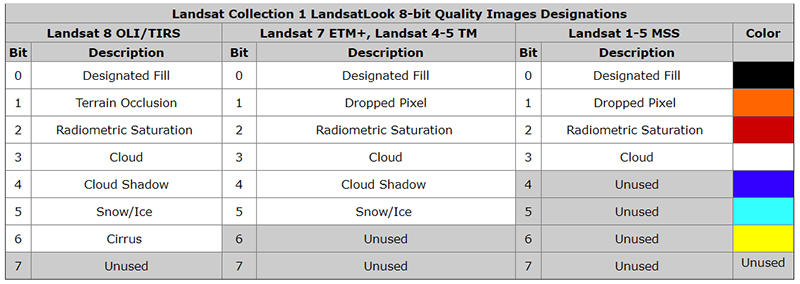

It is recommended that the LandsatLook images not be used for scientific analysis!     

### Open the dataset

The LandsatLook data is stored in three GeoTIFF files:
```
LC08_L1TP_198024_20200917_20201006_01_T1.tif
LC08_L1TP_198024_20200917_20201006_01_T1_QB.tif
LC08_L1TP_198024_20200917_20201006_01_T1_TIR.tif
```
The first file is the natural color image and that is the one we are going to load.

In [ ]:
# set the filename and filepath
path = './'
lsNciFile = 'LC08_L1TP_198024_20200917_20201006_01_T1.tif'

# open GeoTIFF dataset as an object 
src = rasterio.open(path + lsNciFile)

# print object
print('dataset object',src)

Rasterio’s `open()` function takes a path string or path-like object and returns an opened dataset object. The path may point 
to a file of any supported raster format. Rasterio will open it using the proper GDAL format driver. Dataset objects have some of the same attributes as Python file objects.

In [ ]:
print('Dataset name', src.name)
print('Read/write mode',src.mode)
print('Close status',src.closed)

## Dataset attributes

Properties of the raster data stored in the GeoTIFF can be accessed through attributes of the opened dataset object. Some examples to get to the meta data are given below (instead of printing you can of course also assign to variable names) 

In [ ]:
# print out metadata information
print(src.meta)

In [ ]:
for key in src.meta:
  print(key,': ',src.meta[key])

In [ ]:
print('Number of bands',src.count)
print('Number of columns',src.width)
print('Number of rows',src.height)

Dataset objects have bands and this example has a band count of 3. The LandsatLook data happens to be RGB data.

A dataset band is an array of values representing the partial distribution of a single variable in 2-dimensional (2D) space. All band arrays of a dataset have the same number of rows and columns. The variable represented by the example dataset’s three bands are `uint8` RGB values (0...255). The array of data values is 7801 columns wide and 7891 rows high.

It is possible that dataset attributes expose the properties of all dataset bands via a tuple of values, one per band, but this is not the case in our example.

Other attributes are derived, such as

In [ ]:
print(src.bounds)
print('Indexes',src.indexes)

## Dataset georeferencing

The value of bounds (BoundingBox) attribute is derived from a more fundamental attribute: the dataset’s geospatial **transform**.

In [ ]:
transform = src.transform
print(type(transform))
print(transform)

A dataset’s transform is an affine transformation matrix that maps pixel locations in (row, col) coordinates to (x, y) spatial positions. The Affine object is a named tuple with elements a, b, c, d, e, f corresponding to the elements in the matrix equation below, in which a pixel’s image coordinates are x, y and its world coordinates are x', y'.:
```
| x' |   | a b c | | x |
| y' | = | d e f | | y |
| 1  |   | 0 0 1 | | 1 |
```
The product of this matrix and (0, 0), the row and column coordinates of the upper left corner of the dataset, is the spatial position of the upper left corner. The position of the lower right corner is obtained similarly.

In [ ]:
BB= [ [ src.transform * (0, 0) ],
      [ src.transform * (src.width, src.height) ]]
print(BB)

The result is the same as the output of the **bounds** atribute. 

Of a more practical use, the **bouds** attribute can be used to compute the extent parameter for matplotlib's `imshow`
```
extent = [ src.bounds.left ,  src.bounds.right ,  src.bounds.bottom ,  src.bounds.top ]

```

In [ ]:
extent = [ src.bounds.left ,  src.bounds.right ,  src.bounds.bottom ,  src.bounds.top ]
print(extent)

The coordinate reference system (CRS) for the the coordinates is given by the **crs** attribute. 

In [ ]:
print(type(src.crs))
print(src.crs)

The number that is returned is a so-called EPSG Geodetic Parameter Dataset code. Looking the code up on https://spatialreference.org/ref/epsg/, returns the following information

> EPSG:32631   WGS 84 / UTM zone 31N
>
> WGS84 Bounds: 0.0000, 0.0000, 6.0000, 84.0000
> Projected Bounds: 166021.4431, 0.0000, 833978.5569, 9329005.1825
> Scope: Large and medium scale topographic mapping and engineering survey.
> Area: World - N hemisphere - 0°E to 6°E - by country

This UTM (Universal Transverse Mercator) system  is used for mapping areas in the Northern Hemisphere between 0 and 6 degrees East. 

Rasterio follows pyproj and uses PROJ.4 syntax in dict form as its native CRS syntax. If you want a WKT representation of the CRS, see the CRS class’s wkt attribute.
```
>>> src.crs.wkt
```
This gives the all the information you (or PROJ) needs for coordinates transformations.

Rasterio uses under the hood the `pyproj` module, which provides a interface to the `PROJ`  generic coordinate transformation software that transforms geospatial coordinates from one coordinate reference system (CRS) to another. This includes cartographic projections as well as geodetic transformations, see https://proj.org/ .

In [ ]:
print(src.crs.wkt)

Between the crs attribute and transform the georeferencing of a raster dataset is described and the dataset can compared to other GIS datasets.

## Reading raster data

The `read()` method returns a Numpy N-D array. If there are multiple bands, in our case three, the read() method returns a 3-D array. On the first axis (axis=0) are the 3 bands, followed by 7891 rows (axis=1)  and 7801 columns (axis=2).

Data from a raster band can also be accessed by the band’s index number. Following the GDAL convention, bands are indexed from 1. The result is a 2-D array.

In [ ]:
lsData = src.read()
print('lsData shape',lsData.shape)

In [ ]:
print('Indexes',src.indexes)
band1 = src.read(1)
band2 = src.read(2)
band3 = src.read(3)
print('Band-1 shape',band1.shape)
print('Band-2 shape',band2.shape)
print('Band-3 shape',band3.shape)

## Spatial indexing

Datasets have an **index()** method for getting the array indices corresponding to points in georeferenced space. To get the value for the pixel 100 kilometers east and 50 kilometers south of the dataset’s upper left corner, do the following
```
x, y = (src.bounds.left + 100000, src.bounds.top - 50000)
row, col = src.index(x, y)
band1[row, col]
```
as is shown in the example below.

In [ ]:
x, y = (src.bounds.left + 100000, src.bounds.top - 50000)
row, col = src.index(x, y)
print('row, col',row,col)

value = band1[row, col]
print('value band1',value)
value = src.read(1)[row,col]
print('idem ',value)

values = lsData[:,row,col]
print('all values',values)
values = src.read()[:,row,col]
print('all values',values)

To get the spatial coordinates of a pixel, use the dataset’s **xy()** method. The coordinates of the center of the image can be computed like this
```
dataset.xy(src.height // 2, src.width // 2)
```
as we demonstrate below

In [ ]:
x, y = src.xy(src.height // 2, src.width // 2)
print('x, y',x,y)

## Plotting with matplotlib

The read method returns N-D numpy arrays that can be plotted by standard maplotlib functions. To plot the three bands in separate subplots, using imshow, is straightforward 

In [ ]:
%matplotlib inline
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
axr.imshow(band1, cmap='Reds')
axr.set_title('red channel')
axg.imshow(band2, cmap='Greens')
axg.set_title('green channel')
axb.imshow(band3, cmap='Blues')
axb.set_title('blue channel')
plt.show()

To plot the RGB data in a single plot is a bit more involved. Supported array shapes by `imshow` are

- (M, N): an image with scalar data. The values are mapped to colors using normalization and a colormap. See parameters norm, cmap, vmin, vmax.
- (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
- (M, N, 4): an image with RGBA values (0-1 float or 0-255 int), i.e. including transparency.

The first two dimensions (M, N) define the rows and columns of the image.

The shape returned by the `read()` methods is (3, M, N). So, to plot with `imshow` we have to move the first axis to the end using the numpy function `moveaxis(x, axis1, axis2)` 

The result is shown below, together with the use of the **extent** variable computed from the **bounds** attitribute, where we dilligently divided by *1000* to obtain units in km.

In [ ]:
print('Org shape lsData',lsData.shape)
rgb= np.moveaxis(lsData, 0, -1)
print('New shape RGB',rgb.shape)

extent = np.array([ src.bounds.left ,  src.bounds.right ,  src.bounds.bottom ,  src.bounds.top ]) / 1000
print('extent',extent)

plt.figure(figsize=(12, 12))
fig = plt.imshow(rgb, extent=extent) 
plt.title(lsNciFile)
plt.ylabel('UTM 31N North [km]')
plt.xlabel('UTM 31N East [km]')
plt.show()

## Rasterio plotting

Rasterio also provides `rasterio.plot.show()` to perform common tasks such as displaying multi-band images as RGB and labeling the axes with proper geo-referenced extents. 

The first argument to show() represent the data source to be plotted. This can be a 

- dataset object opened in ‘r’ mode,
- a single band of a source, represented by a (src, band_index) tuple,
- a numpy ndarray, 2D or 3D in rasterio band order.

The following examples show a few of the capabilities

In [ ]:
from rasterio.plot import show

plt.figure(figsize=(12,12))
show(src)
plt.show()

In [ ]:
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show((src, 1), ax=axr, cmap='Reds', title='red channel')
show((src, 2), ax=axg, cmap='Greens', title='green channel')
show((src, 3), ax=axb, cmap='Blues', title='blue channel')
plt.show()

In [ ]:
from rasterio.plot import show_hist

show_hist(src, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")
plt.show()

## Close a rasterio dataset

As rasterio dataset are Python dataset object the can be closed. To close a dataset, call its close() method.
```
   src.close()
```
After it’s closed, data can no longer be read. However, data that is stored in N-D arrays will be still available.

In [ ]:
print('Closed?',src.closed)
print(src)
print(lsData.shape)

src.close()
print('Closed?',src.closed)
print(src)
print(lsData.shape)

## Exercises

To get some practice yourself you are asked to do the following

- read in the LandsatLook **Thermal Image** and **Quality Image** and plot the images and histograms
- read in the Sentinel-2 NDVI dataset for assignment 3 and plot the NDVI for the first day

### Thermal Image and Quality Image

Please comment on the thermal and quality images, what do they mean, what is different from the natural color image? How to plot the thermal image, gray scale or pseudo-color? What colors do you use for the quality image? Are the colors for the natural color image really natural?


### Sentinel-2 NDVI dataset

For assignment 3 a Sentinel-2 dataset of NDVI is used. The analysis is performed over Sector BXII, an agricultural area located close to Sevilla (Spain). Input data files are:

- `NDVI_BXII_time_series_2017_2018_S2A_SP.tif`  (Geotiff with NDVI time series)
- `NDVI_BXII_time_series_image_lists.csv`  (csv file with the image dates)

Make a scaled image plot of unfiltered NDVI for the first day. What do you use as colormap for the NDVI? 

It is very important to select a good colormap for the NDVI. Have a look for instance at the following article https://publiclab.org/notes/cfastie/08-26-2014/new-ndvi-colormap

This is also the topic of Exercise 4.

## Further reading

https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/landsat-in-Python/

[End of this notebook]